### Evaluating DR techniques / hyperparameters using measures

In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import os
from metrics import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import importlib
from numba import cuda

from lsnc import lsnc
import metrics as mts
import json

importlib.reload(lsnc)
importlib.reload(mts)

## turn off warning
import warnings
warnings.filterwarnings("ignore")

## generating the list of datasets
datasets = []
for directory in os.listdir("./labeled-datasets/npy/"):
	if (
		directory != ".DS_Store"
		and directory != "README.md"
		and directory != ".gitignore"
		and not directory.endswith(".zip")
	):
		datasets.append(directory)

dr_measures = [
	"ls_btw_ch", "lc_btw_ch", "ls_dsc", "lc_dsc", "cohev", "stead",
	"trust", "conti", "mrre_hl", "mrre_lh",
	"kl_div", "dtm", "dsc", "sil"
]
dr_measures_name = [
	"Label-Stretching [CH$_{btwn}$]", "Label-Compression [CH$_{btwn}$]", 
	"Label-Stretching [DSC]", "Label-Compression [DSC]",
	"Cohesiveness", "Steadiness", 
	"Trustworthiness", "Continuity", "MRRE-HL", "MRRE-LH",
	"1 - KL-Divergence", "1 - DTM", "Silhouette",
]

# datasets.remove("rice_seed_gonen_jasmine")
# datasets.remove("sentiment_labeld_sentences")
# datasets.remove("epileptic_seizure_recognition")
# datasets.remove("dry_bean")
# datasets.remove("hate_speech")
# datasets.remove("crowdsourced_mapping")
# datasets.remove("durum_wheat_features")


In [2]:
def run_all_metrics(raw, emb, labels, k_cand, sigma_cand, results):
	"""
	compute all metrics
	"""
	if results == None:
		final_results = {}
	else:
		final_results = results
	## LS & LC
	if "ls_btw_ch" not in final_results:
		lsnc_obj = lsnc.LSNC(raw, emb, labels)
		results = lsnc_obj.run()
		final_results["ls_btw_ch"] = results["ls"]
		final_results["lc_btw_ch"] = results["lc"]
	
	if "ls_dsc" not in final_results:
		lsnc_obj = lsnc.LSNC(raw, emb, labels, cvm="dsc")
		results = lsnc_obj.run()
		final_results["ls_dsc"] = results["ls"]
		final_results["lc_dsc"] = results["lc"]

	## Steadiness & Cohesiveness
	if "stead" not in final_results:
		results = mts.stead_cohev(raw, emb)
		final_results["stead"] = float(results["stead"])
		final_results["cohev"] = float(results["cohev"])


	## Silhouette
	if "sil" not in final_results:
		final_results["sil"] = float(mts.silhouette(emb, labels))
	
	if "dsc" not in final_results:
		final_results["dsc"] = mts.dsc(emb, labels)

	## Trust / Conti / MRRE
	if "trust" not in final_results:
		trust, conti, mrre_hl, mrre_lh = 0, 0, 0, 0
		for k in k_cand:
			results = mts.trust_conti_mrre(raw, emb, k = k)
			trust += float(results["trust"])
			conti += float(results["conti"])
			mrre_hl += float(results["mrre_hl"])
			mrre_lh += float(results["mrre_lh"])
		final_results["trust"] = trust / len(k_cand)
		final_results["conti"] = conti / len(k_cand)
		final_results["mrre_hl"] = mrre_hl / len(k_cand)
		final_results["mrre_lh"] = mrre_lh / len(k_cand)

	## KL / DTM
	if "kl_div" not in final_results:
		kl_div, dtm = 0, 0, 
		for sigma in sigma_cand:
			results = mts.kl_div_rmse_dtm(raw, emb, sigma = sigma)
			kl_div += results["kl_div"]
			dtm += results["dtm"]
		final_results["kl_div"] = float(kl_div / len(sigma_cand))
		final_results["dtm"] = float(dtm / len(sigma_cand))

	return final_results	

## calculate the metrics
k_cand = [5, 10, 15, 20, 25, 30]
sigma_cand = [0.01, 0.1, 1]
techniques = ["umap", "tsne", "pca", "lle", "isomap",  "densmap"]

#### Evaluation of different DR techqniues

In [4]:
cuda.select_device(1)

results_df = pd.DataFrame({
	"technique": [],
	"measure": [],
	"dataset": [],
	"score": []
})


for dataset in tqdm(datasets):

	
	if os.path.exists(f"./evaluating_dr/techniques/{dataset}.json"):
		results = json.load(open(f"./evaluating_dr/techniques/{dataset}.json", "r"))

	else:
		if os.path.exists(f"./labeled-datasets_embedding/{dataset}/lda.npy"):
			print(dataset)
			lda_emb = np.load(f"./labeled-datasets_embedding/{dataset}/lda.npy")
			umap_emb = np.load(f"./labeled-datasets_embedding/{dataset}/umap.npy")
			tsne_emb = np.load(f"./labeled-datasets_embedding/{dataset}/tsne.npy")
			pca_emb = np.load(f"./labeled-datasets_embedding/{dataset}/pca.npy")
			isomap_emb = np.load(f"./labeled-datasets_embedding/{dataset}/isomap.npy")
			lle_emb = np.load(f"./labeled-datasets_embedding/{dataset}/lle.npy")
			densmap_emb = np.load(f"./labeled-datasets_embedding/{dataset}/densmap.npy")
			labels = np.load(f"./labeled-datasets/npy/{dataset}/label.npy")
			raw = np.load(f"./labeled-datasets/npy/{dataset}/data.npy")
			raw = (raw - raw.mean(axis=0)) / raw.std(axis=0)
			raw = raw[:, ~np.isnan(raw).any(axis=0)]


			results= {}
			results["umap"] = run_all_metrics(raw, umap_emb, labels, k_cand, sigma_cand)
			results["tsne"] = run_all_metrics(raw, tsne_emb, labels, k_cand, sigma_cand)
			results["pca"] = run_all_metrics(raw, pca_emb, labels, k_cand, sigma_cand)
			results["isomap"] = run_all_metrics(raw, isomap_emb, labels, k_cand, sigma_cand)
			results["lle"] = run_all_metrics(raw, lle_emb, labels, k_cand, sigma_cand)
			results["densmap"] = run_all_metrics(raw, densmap_emb, labels, k_cand, sigma_cand)

			with open(f"./evaluating_dr/techniques/{dataset}.json", "w") as f:
				json.dump(results, f)
		else:
			continue
	
	for technique in techniques:
		for measure in dr_measures:
			results_df = results_df.append({
				"technique": technique,
				"measure": measure,
				"dataset": dataset,
				"score": results[technique][measure]
			}, ignore_index = True)


results_df.to_csv("./evaluating_dr/techniques.csv", index = False)

100%|██████████| 94/94 [00:23<00:00,  4.08it/s]


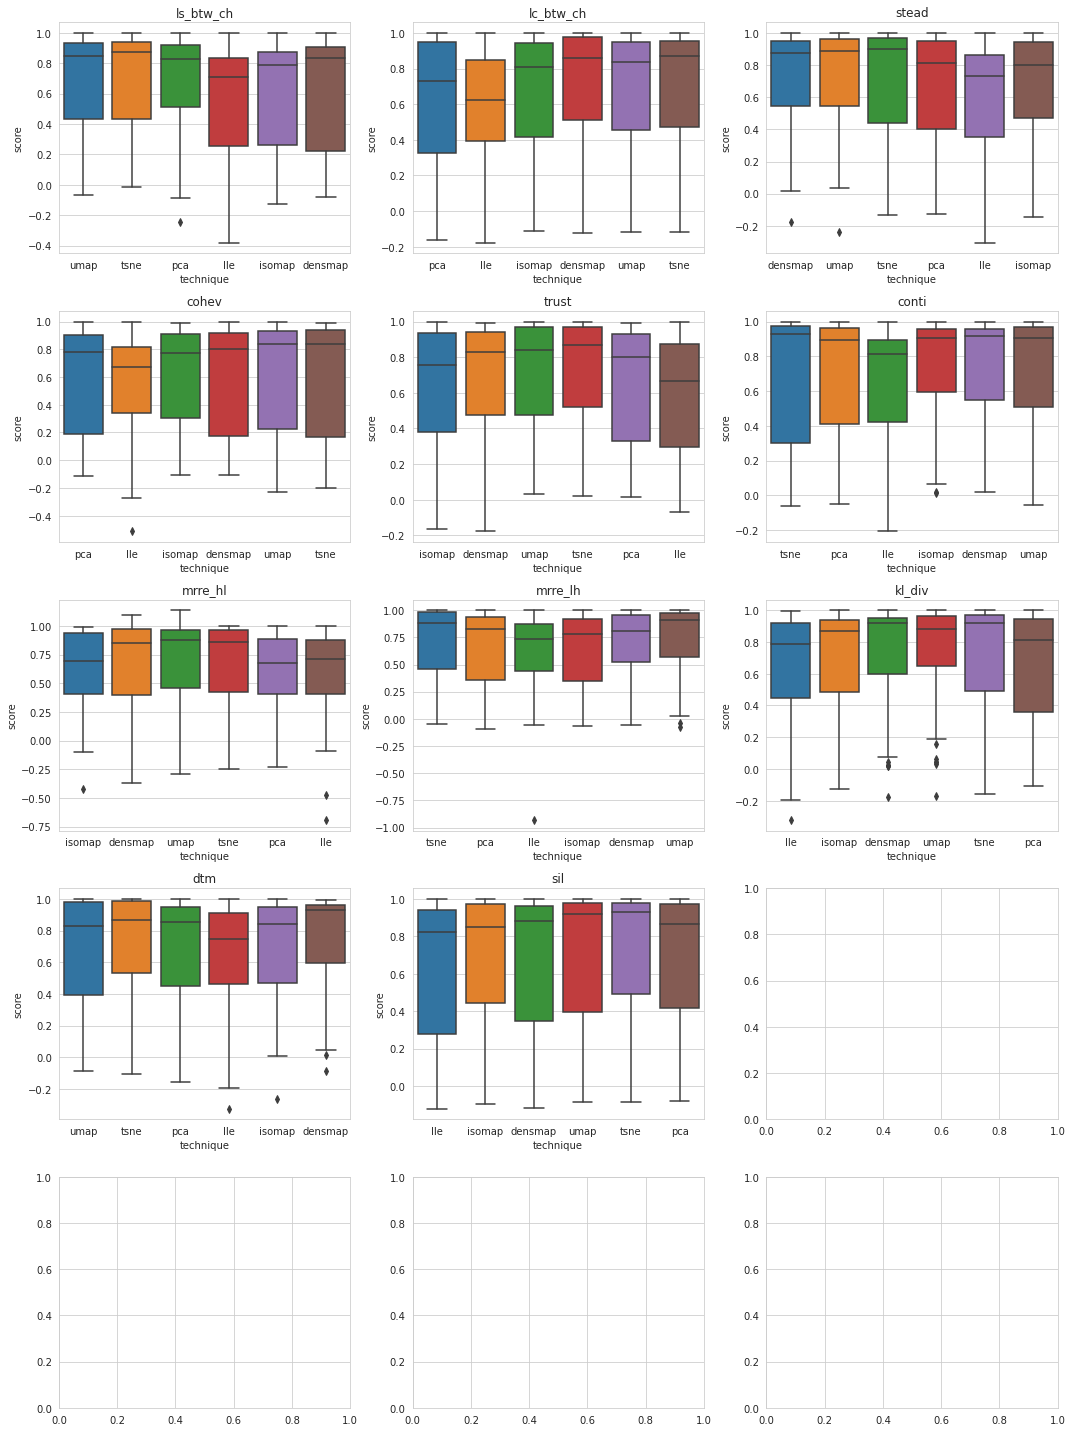

In [8]:
## plot the results as a series of boxplot for each measure

sns.set_style("whitegrid")
measure_len = len(results_df) / len(dr_measures)

full_measures = [
	"ls_btw_ch", "lc_btw_ch",  
	"stead", "cohev", 
	"trust", "conti", 
	"mrre_hl", "mrre_lh", 
	"kl_div", "dtm", "sil"
]

fig, ax = plt.subplots(5, 3, figsize = (15, 20))
for i, measure in enumerate(full_measures):
	ax[i // 3, i % 3].set_title(measure)
	sns.boxplot(x = "technique", y = "score", data = results_df.iloc[int(i * measure_len):int((i + 1) * measure_len)], ax = ax[i // 3, i % 3])

plt.tight_layout()

In [5]:
## transfer results_df into the dataframe that contains the ranking of each technique for each measure

half_measures = [
	"ls_btw_ch", "lc_btw_ch", "stead", "cohev", "trust", "conti", "mrre_hl",  "mrre_lh",   
	
	
	"sil",
	"kl_div", "dtm",   
]


## get ranking for each measure
results_rank = pd.DataFrame({
	"technique": [],
	"measure": [],
	"rank": []
})
for measure in dr_measures:
	techqniues_mean = []
	for technique in techniques:
		techqniues_mean.append(
			results_df[(results_df["technique"] == technique) & (results_df["measure"] == measure)]["score"].mean()
		)
	techniques_rank = np.argsort(techqniues_mean)[::-1]
	for i, technique in enumerate(techniques):
		results_rank = results_rank.append({
			"technique": technique,
			"measure": measure,
			"rank": techniques_rank[i] + 1
		}, ignore_index = True)

## draw bump chart using altair

alt.Chart(results_rank).mark_bar().encode(
	x = alt.X("measure:N", axis = alt.Axis(title = "Measure"), sort=half_measures),
	y = alt.Y("rank:O", axis = alt.Axis(title = "Rank")),
	color = alt.Color("technique:N", legend = alt.Legend(title = "Technique"), sort=techniques)
)

	

alt.Chart(...)

### Evaluation of tsne hyperparameter

In [3]:
cuda.select_device(1)

hp_results_df = pd.DataFrame({
	"technique": [],
	"measure": [],
	"dataset": [],
	"hp": [],
	"score": []
})

hp_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]


for dataset in tqdm(datasets):
	raw = np.load(f"./labeled-datasets/npy/{dataset}/data.npy")
	raw = (raw - raw.mean(axis=0)) / raw.std(axis=0)
	raw = raw[:, ~np.isnan(raw).any(axis=0)]
	labels = np.load(f"./labeled-datasets/npy/{dataset}/label.npy")
	for hp in hp_list:
		try:
			if os.path.exists(f"./evaluating_dr/hyperparameters/{dataset}_{hp}.json"):
				with open(f"./evaluating_dr/hyperparameters/{dataset}_{hp}.json", "r") as f:
					results = json.load(f)
					emb = np.load(f"./labeled-datasets_embedding/{dataset}/tsne_{hp}.npy")
					results = run_all_metrics(raw, emb, labels, k_cand, sigma_cand, results)
			else:
				emb = np.load(f"./labeled-datasets_embedding/{dataset}/tsne_{hp}.npy")
				results = run_all_metrics(raw, emb, labels, k_cand, sigma_cand, {})

			with open(f"./evaluating_dr/hyperparameters/{dataset}_{hp}.json", "w") as f:
				json.dump(results, f)

			for measure in dr_measures:
				hp_results_df = hp_results_df.append({
					"technique": "tsne",
					"measure": measure,
					"dataset": dataset,
					"hp": hp,
					"score": results[measure],
				}, ignore_index = True)
		except:
			print(dataset, hp)



hp_results_df.to_csv("./evaluating_dr/techniques.csv", index = False)

 72%|███████▏  | 68/94 [01:26<01:13,  2.82s/it]

sms_spam_collection 2048


 84%|████████▍ | 79/94 [01:40<00:18,  1.24s/it]

htru2 1
htru2 2
htru2 4
htru2 8
htru2 16
htru2 32
htru2 64
htru2 128
htru2 256
htru2 512
htru2 1024


 85%|████████▌ | 80/94 [01:48<00:47,  3.38s/it]

htru2 2048


 95%|█████████▍| 89/94 [02:00<00:08,  1.76s/it]

human_stress_detection 2048


100%|██████████| 94/94 [02:07<00:00,  1.35s/it]


<Figure size 432x288 with 0 Axes>

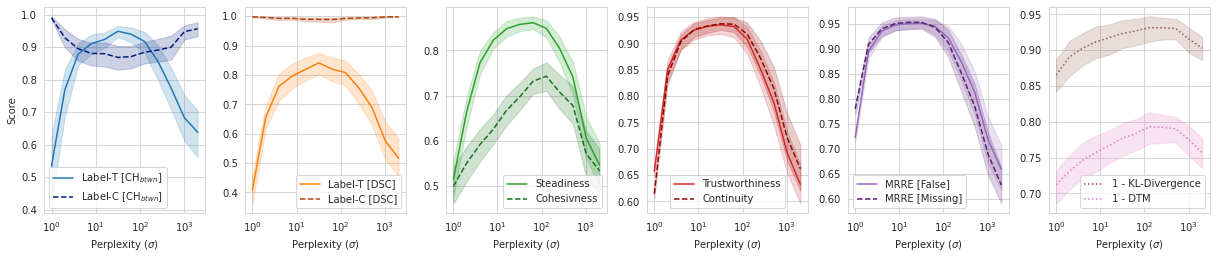

In [9]:
## plot the hp_results_df into kdeplot

plt.clf()
sns.set_style("whitegrid")

hp_results_df["hp"] = hp_results_df["hp"].astype(int)
##
fig, axs = plt.subplots(1, 6, figsize = (17, 3.7))
meausre_pairs = [("lc_btw_ch", "ls_btw_ch"), ("lc_dsc", "ls_dsc"), ("stead", "cohev"), ("trust", "conti"), ("mrre_lh", "mrre_hl" ), ("kl_div", "dtm")]
measure_names = [
	("Label-T [CH$_{btwn}$]", "Label-C [CH$_{btwn}$]"), ("Label-T [DSC]", "Label-C [DSC]"), 
	("Steadiness", "Cohesivness"), 
	("Trustworthiness", "Continuity"), ("MRRE [False]", "MRRE [Missing]"), 
	("1 - KL-Divergence", "1 - DTM")
]



tab10 = sns.color_palette("tab10")
tab10dark = sns.color_palette("dark")


colors = [(tab10[0], tab10dark[0]), (tab10[1], tab10dark[1]), (tab10[2], tab10dark[2]), (tab10[3], tab10dark[3]), (tab10[4], tab10dark[4]), (tab10[5], tab10[6])]
linestyle_list = [
	["solid", "dashed"],
	["solid", "dashed"],
	["solid", "dashed"],
	["solid", "dashed"],
	["solid", "dashed"],
	["dotted","dotted"],
]

minus_1 = {"kl_div", "dtm", "dsc"}

for i, measure_pair in enumerate([("lc_btw_ch", "ls_btw_ch"), ("lc_dsc", "ls_dsc"), ("stead", "cohev"), ("trust", "conti"), ("mrre_hl", "mrre_lh"), ("kl_div", "dtm")]):
	if type(measure_pair) == tuple:
		filtering = np.logical_or((hp_results_df["measure"] == measure_pair[0]), (hp_results_df["measure"] == measure_pair[1]))
	else:
		filtering = (hp_results_df["measure"] == measure_pair)
	
	if measure_pair in minus_1:
		## minus 1 from the score
		hp_results_df.loc[filtering, "score"] = 1 - hp_results_df.loc[filtering, "score"]

	ax = axs[i]
	
	sns.lineplot(
		x = "hp", y = "score", hue = "measure", data = hp_results_df[filtering], ax = ax, palette=colors[i], hue_order=measure_pair, legend = False
	)

	if type(measure_pair) == tuple:
		ax.lines[0].set_linestyle(linestyle_list[i][0])
		ax.lines[1].set_linestyle(linestyle_list[i][1])

	## set x axis log
	ax.set_xscale("log")

	## set label with measures_name
	ax.set_xlabel("Perplexity ($\sigma$)")
	ax.set_ylabel("Score" if i == 0 else "")
	## set legend
	ax.legend(labels=measure_names[i], title=None)

	## add red dashed line in 5 and 50

plt.tight_layout()
plt.savefig("./evaluating_dr/techniques.png", dpi = 300)
plt.savefig("./evaluating_dr/techniques.pdf", dpi = 300)